README.md

Notebook para análise de seções sísmicas individuais e clustering de seus atributos concatenados. Os dados são tratados com classes específicas, dados sísmicos e a interpretação dos horizontes, com funções de cálculo de atributos dedicadas. A visualização passa por plots individuais e coletivos. O clustering suporta KMeans e EM, basta selecionar o método, a lista de atributos para concatenação e o número de clusters.

# Setup

Bibliotecas necessárias.

In [1]:
import segyio
from ipywidgets import FileUpload, interact, IntSlider, fixed
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.ndimage
import ipywidgets as widgets

from scipy.signal import hilbert
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Atributos e superfície

Classes para tratamento de dados. _atributos_ é a classe para leitura e tratamento da amplitude sísmica, bem como funções de cálculo de diversos atributos sísmicos. _superficie_ é a classe para tratar os horizontes (linhas) que segmentam as regiões sísmicas.

Após o cálculo dos atributos é possível chamar esses dados a partir de um objeto da classe _atributos_. Segue a lista dos atributos calculados, <variável _atributos_> -> _secao_:



* Amplitude sísmica: <variável _atributos_>.sismica
* Envelope: <variável _atributos_>.envelope
* Fase: <variável _atributos_>.fase
* Frequência: <variável _atributos_>.freq
* Sweetness: <variável _atributos_>.sweetness
* RMS: <variável _atributos_>.rms
* TecVA: <variável _atributos_>.tecva
* Semblance de alta resolução: <variável _atributos_>.semblance
* Sobel: <variável _atributos_>.sobel
* Marfurt: <variável _atributos_>.marfurt

In [2]:
class atributos():
  def __init__(self, path, espacamento = 1, profundidade = None):
    self.path = path
    if type(path) == str:
      self.X = np.load(self.path)
    else:
      self.X = np.copy(path)
    self.sismica = self.X
    self.resolucao = espacamento
    deltaz = profundidade
    if not deltaz:
      deltaz = [self.X.shape[1], 0]
    self.extent = [1, self.X.shape[0] * self.resolucao, deltaz[1], deltaz[0]]

  def linhas(self, ariri, barravelha, camboriu):
    self.ariri = ariri
    self.barravelha = barravelha
    self.camboriu = camboriu

  def _complexo(self):
      self.envelope, self.fase, self.freq, self.sweetness = complexo(self.X)

  def _coherence(self):
    self.semblance, self.sobel, self.marfurt = coherence(self.X)

  def _tecva(self):
    self.tecva, self.rms = tecva(self.X)

In [3]:
def complexo(X):
  envelope = np.zeros(shape = X.shape)
  fase = np.zeros(shape = X.shape)

  for i in range(X.shape[0]):
    signal = hilbert(X[i, :])

    envelope[i, :] = np.abs(signal)
    fase[i, :] = np.unwrap(np.angle(signal))
  freq = np.diff(fase) / 2 / np.pi
  freq = np.hstack((freq[:, 0:1], freq))
  sweetness = envelope / np.sqrt(np.abs(freq + 1e-6))

  return envelope, fase, freq, sweetness

In [4]:
def coherence(X):
  gersztenkorn = _moving_window(X, _gersztenkorn, (3, 3))
  gersztenkorn = np.nan_to_num(gersztenkorn)

  sobel = np.sqrt(sum(scipy.ndimage.sobel(gersztenkorn, axis) ** 2 for axis in range(2)))

  marfurt = _moving_window(X, _marfurt, (3, 3))
  marfurt = np.nan_to_num(marfurt)

  return gersztenkorn, sobel, marfurt

def _moving_window(data, func, window):
  wrapped = lambda x: func(x.reshape(window))
  return scipy.ndimage.generic_filter(data, wrapped, window)

def _gersztenkorn(region):
  region = region.reshape(-1, region.shape[-1])
  cov = region.dot(region.T)
  vals = np.linalg.eigvalsh(cov)
  return vals.max() / vals.sum()

def _marfurt(region):
  region = region.reshape(-1, region.shape[-1])
  ntraces, nsamples = region.shape
  cov = region.dot(region.T)
  sembl = cov.sum() / cov.diagonal().sum()
  return sembl / ntraces

In [5]:
def tecva(X):
  fs = X.shape[1]
  rms = np.zeros(shape = X.shape)
  tecva = np.zeros(shape = X.shape)

  for i in range(X.shape[0]):
    signal = X[i, :]

    M, Minf, Msup = _sce(signal)
    rms[i, :] = _rms(signal, M, Minf, Msup)
    tecva[i, :] = np.imag(hilbert(rms[i, :]) * (-1))

  return tecva, rms

def _sce(signal, dx = 1):
    # dy = np.diff(signal) / dx

    M = 1
    # centro = np.argmax(dy)
    centro = np.argmax(np.abs(np.diff(np.angle(hilbert(signal)))))

    menor = signal[centro]
    parcial = menor
    k = 0
    while parcial <= menor:
      k -= 1
      menor = parcial
      try:
        parcial = signal[centro + k]
      except IndexError:
        break
    k += 1
    M += np.abs(k)
    Minf = np.abs(k)

    maior = signal[centro]
    parcial = maior
    k = 0
    while parcial >= maior:
      k += 1
      maior = parcial
      try:
        parcial = signal[centro + k]
      except IndexError:
        break
    k -= 1
    M += np.abs(k)
    Msup = np.abs(k)

    return M, Minf, Msup

def _rms(signal, M, Minf, Msup):
    rms = np.zeros(shape = signal.shape)
    for k in range(len(signal)):
      parcial = 0
      for kk in range(k - Minf, k + Msup + 1):
        try:
          parcial += signal[kk]**2
        except IndexError:
          pass
      rms[k] = np.sqrt(parcial / M)
    return rms

In [6]:
class superficie():
  def __init__(self, path, csv = False):
    self.path = path
    self.id = path.split('/')[-1].split('.')[0]
    if csv:
      columns = ['inline', 'crossline', 'z']
      self.data = pd.read_csv(self.path, header = None, names = columns)
    else:
      columns = ['x', 'y', 'z', 'inline', 'crossline']
      self.data = pd.read_csv(self.path, sep = '\t', header = None, names = columns).drop(columns = ['x', 'y'])
    self.offsets = [2100, 3650]
    self.shape = [2898, 1345]

  def line(self, i, crossline = False, offset = False):
    inline = int(crossline) # inline = 0 se crossline é True, inline = 1 se crossline é False
    if inline == 0:
      linha = self.data.loc[self.data['inline'] == i + offset * self.offsets[1]][['z', 'crossline']].values
    else:
      linha = self.data.loc[self.data['crossline'] == i + offset * self.offsets[0]][['z', 'inline']].values
    linha = self._remove_offset(linha, inline)
    linha = self._interpolate(linha)
    return linha

  def _remove_offset(self, linha, inline = 0):
    linha[:, -1] -= self.offsets[inline]
    lim = self.shape[inline] - 1
    borda = (linha[:, -1] > lim) + (linha[:, -1] < 0)
    linha = linha[~borda, :]
    return linha

  def _interpolate(self, linha):
    i = 0
    log = []
    for ii, coluna in enumerate(linha):
      if coluna[-1] == i:
        log.append(coluna)
        i += 1
      else:
        delta = coluna[-1] - i
        xp = np.vstack([linha[ii-1], coluna])
        for j in range(int(delta)):
          interpolado = np.interp(i + j, xp[:, 1], xp[:, 0])
          log.append([interpolado, i + j])
        log.append(coluna)
        i += j + 2
    log = np.array(log)

    for coluna in linha:
      assert (coluna == log[int(coluna[-1]), :]).all()
    linha = np.flip(log, axis = 1)
    return linha

## Utils

Funções auxiliares para plot e clustering.

In [7]:
def plot(obj, atributo, color = 'gray', linhas = False, percentil = 100, export = None):
  fig = plt.figure(figsize = (24, 10))
  vmin = np.percentile(atributo, 100 - percentil)
  vmax = np.percentile(atributo, percentil)
  plt.imshow(atributo.T, cmap = color, extent = obj.extent, aspect = 'auto', vmin = vmin, vmax = vmax)
  if linhas:
    plot_linhas(obj, plt)

  if export:
    plt.savefig(export)

In [8]:
def plot_nobj(atributo, extent, color = 'gray', percentil = 99, export = None):
  fig = plt.figure(figsize = (24, 10))
  vmin = np.percentile(atributo, 100 - percentil)
  vmax = np.percentile(atributo, percentil)
  plt.imshow(atributo.T, cmap = color, extent = extent, aspect = 'auto', vmin = vmin, vmax = vmax)
  plt.show()

In [9]:
def plot_linhas(obj, axis):
  axis.plot((obj.ariri[:, 0] + 1)*obj.resolucao, obj.ariri[:, 1], color = 'green', linewidth = 3)
  axis.plot((obj.barravelha[:, 0] + 1)*obj.resolucao, obj.barravelha[:, 1], color = 'green', linewidth = 3)
  axis.plot((obj.camboriu[:, 0] + 1)*obj.resolucao, obj.camboriu[:, 1], color = 'green', linewidth = 3)

In [10]:
def plot_sliding(cube, axis, target):
  global INLINE_TARGET, CROSSLINE_TARGET
  assert axis == 'inline' or axis == 'crossline'
  if axis == 'inline':
    # slice_ = cube[idx, :, :]
    idx = int(np.where(INLINES == target)[0][0])
    slice_ = cube[idx, :, :]
    extent = EXTENT_INLINE
    INLINE_TARGET = target
  else:
    # slice_ = cube[:, idx, :]
    idx = int(np.where(CROSSLINES == target)[0][0])
    slice_ = cube[:, idx, :]
    extent = EXTENT_CROSSLINE
    CROSSLINE_TARGET = target

  plot_nobj(slice_, extent = extent)

In [11]:
def subplot(obj, atributos, color = 'gray', linhas = False, percentil = 100, export = None):
  assert not len(atributos) % 2, 'O número de atributos no subplot deve ser par, ou o último ficará escondido'
  nrows, ncols = (len(atributos) // 2, 2)
  fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (24, 5 * nrows))
  if len(atributos) == 2:
    ax = ax.reshape(1, -1)

  for i in range(nrows):
    for j in range(ncols):
      atributo = atributos[i*2 + j]
      vmin = np.percentile(atributo, 100 - percentil)
      vmax = np.percentile(atributo, percentil)
      ax[i, j].imshow(atributo.T, aspect = 'auto', extent = obj.extent, vmin = vmin, vmax = vmax, cmap = color);
      if linhas:
        plot_linhas(obj, ax[i, j])

  if export:
    plt.savefig(export)

In [12]:
def concatenate(atributos):
  X = np.copy(atributos[0]).reshape(-1, 1)

  for atributo in atributos[1:]:
    X = np.concatenate((X, atributo.reshape(-1, 1)), axis = 1)

  return X

## Clustering

Método de clustering, basta selecionar o tipo (KMeans ou EM) _tipo_, o número de clusters _k_ e a lista de atributos concatenados _atributos_.

In [13]:
def clustering_ablation(atributos, k = 4, tipo = 'KMeans'):
  assert tipo in ['KMeans', 'EM'], 'Selecione um método de clustering disponível'
  X = concatenate(atributos)
  shape = atributos[0].shape

  # mahalanobis
  scaler = StandardScaler()
  Z = scaler.fit_transform(X)
  pca = PCA()
  H = pca.fit_transform(Z)

  if tipo == 'KMeans':
    model = KMeans(n_clusters = k, n_init = 'auto').fit(H)
    clusters = model.labels_
  if tipo == 'EM':
    model = GaussianMixture(n_components = k).fit(H)
    clusters =model.predict(H)

  enc = OneHotEncoder()
  onehot = enc.fit_transform(clusters.reshape(-1, 1)).toarray()
  onehot = onehot.reshape([shape[0], shape[1], -1])

  clusters = clusters.reshape(shape)
  return clusters, onehot

## Widget

Ferramentas de interação com o usuário.

In [14]:
resolucao = widgets.FloatText(
    value = 12.5,
    description='Espaçamento:',
    disabled=False
)

In [15]:
deltaz0 = widgets.FloatText(
    value = 2000,
    description='Profundidade inicial:',
    disabled=False
)

In [16]:
deltaz1 = widgets.FloatText(
    value = 8000,
    description='Profundidade final:',
    disabled=False
)

In [17]:
items = [resolucao, deltaz0, deltaz1]
parametros = widgets.Box(children = items)

In [18]:
tipo = widgets.Dropdown(
    options=['KMeans', 'EM'],
    value='KMeans',
    description='Tipo:',
    disabled=False,
)

In [19]:
k = widgets.IntSlider(
    value=4,
    min=2,
    max=100,
    step=1,
    description='Clusters:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

In [20]:
lista = widgets.SelectMultiple(
    options=[('Amplitude sísmica', 'X'), ('Envelope', 'envelope'), ('Fase', 'fase'), ('Frequência', 'freq'), ('Sweetness', 'sweetness'), ('RMS', 'rms'), ('TecVA', 'tecva'), ('Semblance de alta resolução', 'semblance'), ('Sobel', 'sobel'), ('Marfurt', 'marfurt')],
    value=['X'],
    #rows=10,
    description='Atributos:',
    disabled=False
)

In [21]:
items = [tipo, k, lista]
processo = widgets.Box(children = items)

# Inserte SGY aqui

In [3]:
upload = FileUpload(accept = '.sgy')
display(upload)

FileUpload(value=(), accept='.sgy', description='Upload')

In [22]:
parametros

Box(children=(FloatText(value=12.5, description='Espaçamento:'), FloatText(value=2000.0, description='Profundi…

## Backend

In [23]:
# filepath = 'data/sismica_pre_sal.sgy'
filepath = upload.value[0]['name']
segyfile = segyio.open(filepath)

segyfile.mmap()
print(segyfile.bin)

{JobID: 0, LineNumber: 0, ReelNumber: 0, Traces: 0, AuxTraces: 0, Interval: 5000, IntervalOriginal: 0, Samples: 1401, SamplesOriginal: 0, Format: 1, EnsembleFold: 0, SortingCode: 0, VerticalSum: 0, SweepFrequencyStart: 0, SweepFrequencyEnd: 0, SweepLength: 0, Sweep: 0, SweepChannel: 0, SweepTaperStart: 0, SweepTaperEnd: 0, Taper: 0, CorrelatedTraces: 0, BinaryGainRecovery: 0, AmplitudeRecovery: 0, MeasurementSystem: 0, ImpulseSignalPolarity: 0, VibratoryPolarity: 0, ExtAuxTraces: 0, ExtSamples: 0, ExtSamplesOriginal: 0, ExtEnsembleFold: 0, SEGYRevision: 1, SEGYRevisionMinor: 0, TraceFlag: 1, ExtendedHeaders: 0}


In [24]:
data = segyio.tools.cube(filepath)
print(data.shape)

(171, 251, 1401)


In [25]:
INLINES = segyfile.ilines
CROSSLINES = segyfile.xlines

In [26]:
# espacamento = 12.5
# profundidade = [2000, 8000]
espacamento = resolucao.value
profundidade = [deltaz0.value, deltaz1.value]
EXTENT_INLINE = [1, data.shape[1] * espacamento, profundidade[1], profundidade[0]]
EXTENT_CROSSLINE = [1, data.shape[0] * espacamento, profundidade[1], profundidade[0]]

In [27]:
slider_x = IntSlider(min = INLINES[0], max = INLINES[-1], step = 1, value = 0, description = 'inline')
slider_y = IntSlider(min = CROSSLINES[0], max = CROSSLINES[-1], step = 1, value = 0, description = 'crossline')

## Escolha a seção (inline / crossline)

In [28]:
interact(plot_sliding, cube = fixed(data), axis = 'inline', target = slider_x);

interactive(children=(Text(value='inline', description='axis'), IntSlider(value=4004, description='inline', ma…

In [29]:
interact(plot_sliding, cube = fixed(data), axis = 'crossline', target = slider_y);

interactive(children=(Text(value='crossline', description='axis'), IntSlider(value=2330, description='crosslin…

## Exportar a seção em NPY?

In [30]:
'{}_inline_{}.npy'.format(filepath[:-4], INLINE_TARGET)

'data/sismica_pre_sal_inline_4059.npy'

In [31]:
# idx = int(np.where(INLINES == INLINE_TARGET)[0][0])
# np.save('{}_inline_{}.npy'.format(filepath[:-4], INLINE_TARGET), data[idx, :, :])

In [32]:
'{}_crossline_{}.npy'.format(filepath[:-4], CROSSLINE_TARGET)

'data/sismica_pre_sal_crossline_2455.npy'

In [33]:
# idx = int(np.where(INLINES == CROSSLINE_TARGET)[0][0])
# np.save('{}_crossline_{}.npy'.format(filepath[:-4], CROSSLINE_TARGET), data[:, idx, :])

# Clustering

In [34]:
idx = int(np.where(INLINES == INLINE_TARGET)[0][0])
secao = atributos(data[idx, :, :], espacamento, profundidade)

## Cálculo de atributos

In [35]:
secao._complexo()
secao._coherence()
secao._tecva()

## Reprodução

In [36]:
processo

Box(children=(Dropdown(description='Tipo:', options=('KMeans', 'EM'), value='KMeans'), IntSlider(value=4, cont…

In [37]:
clusters, onehot = clustering_ablation([getattr(secao, atr) for atr in lista.value], k = k.value, tipo = tipo.value)

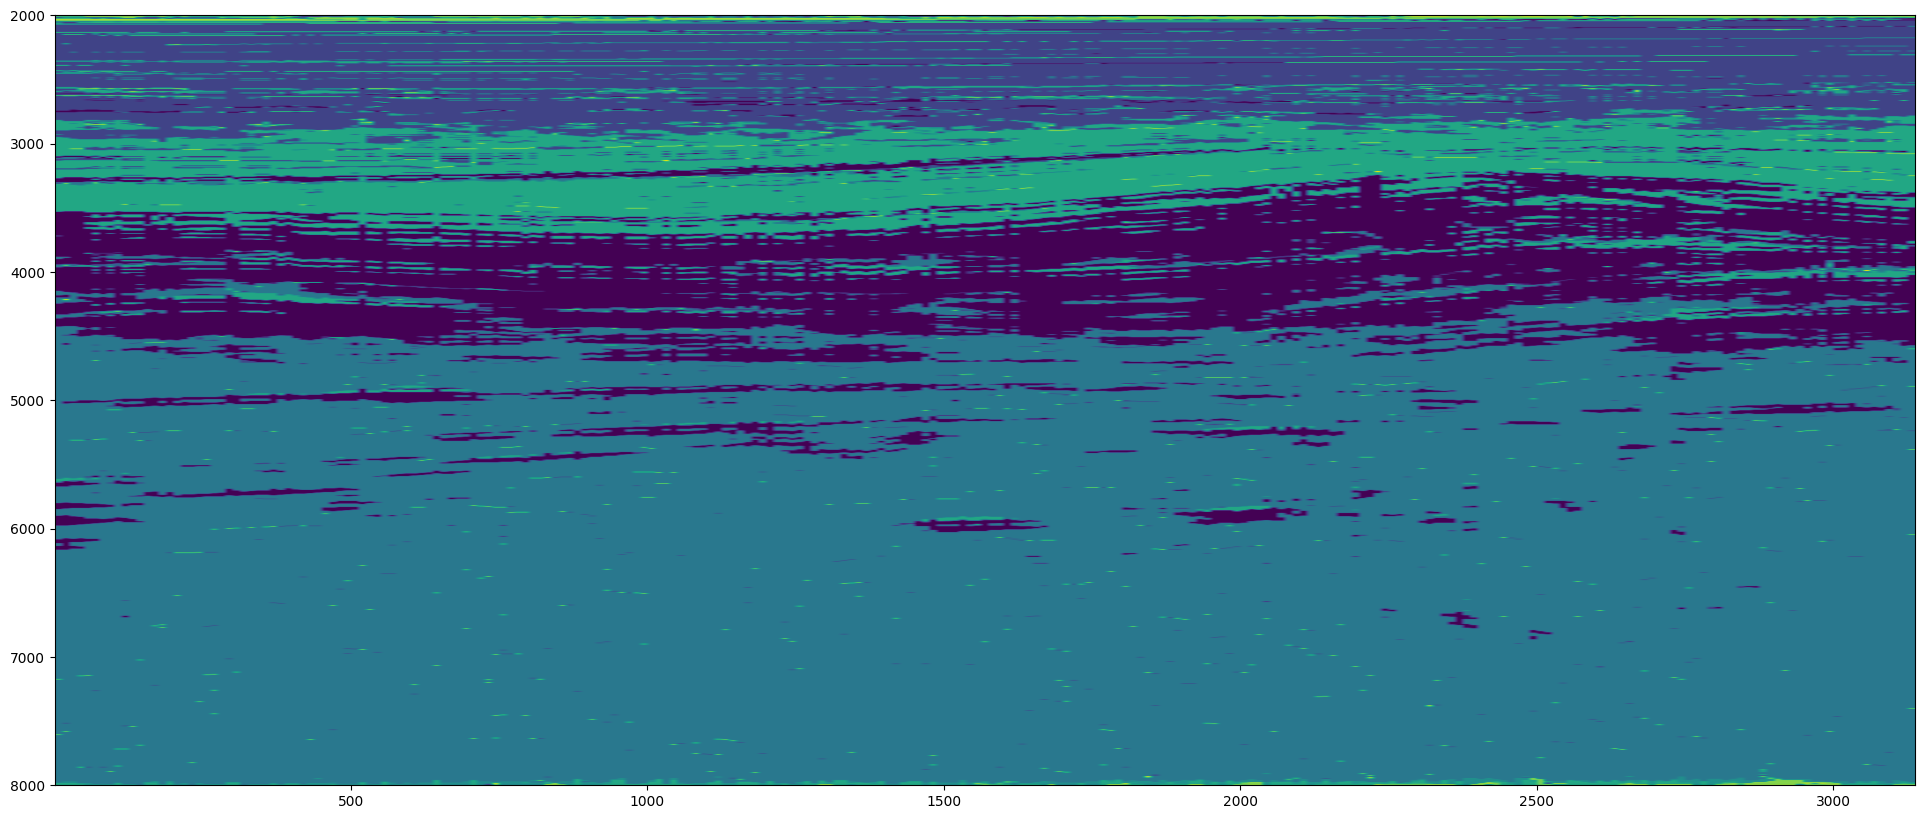

In [39]:
plot(secao, clusters, color = None)

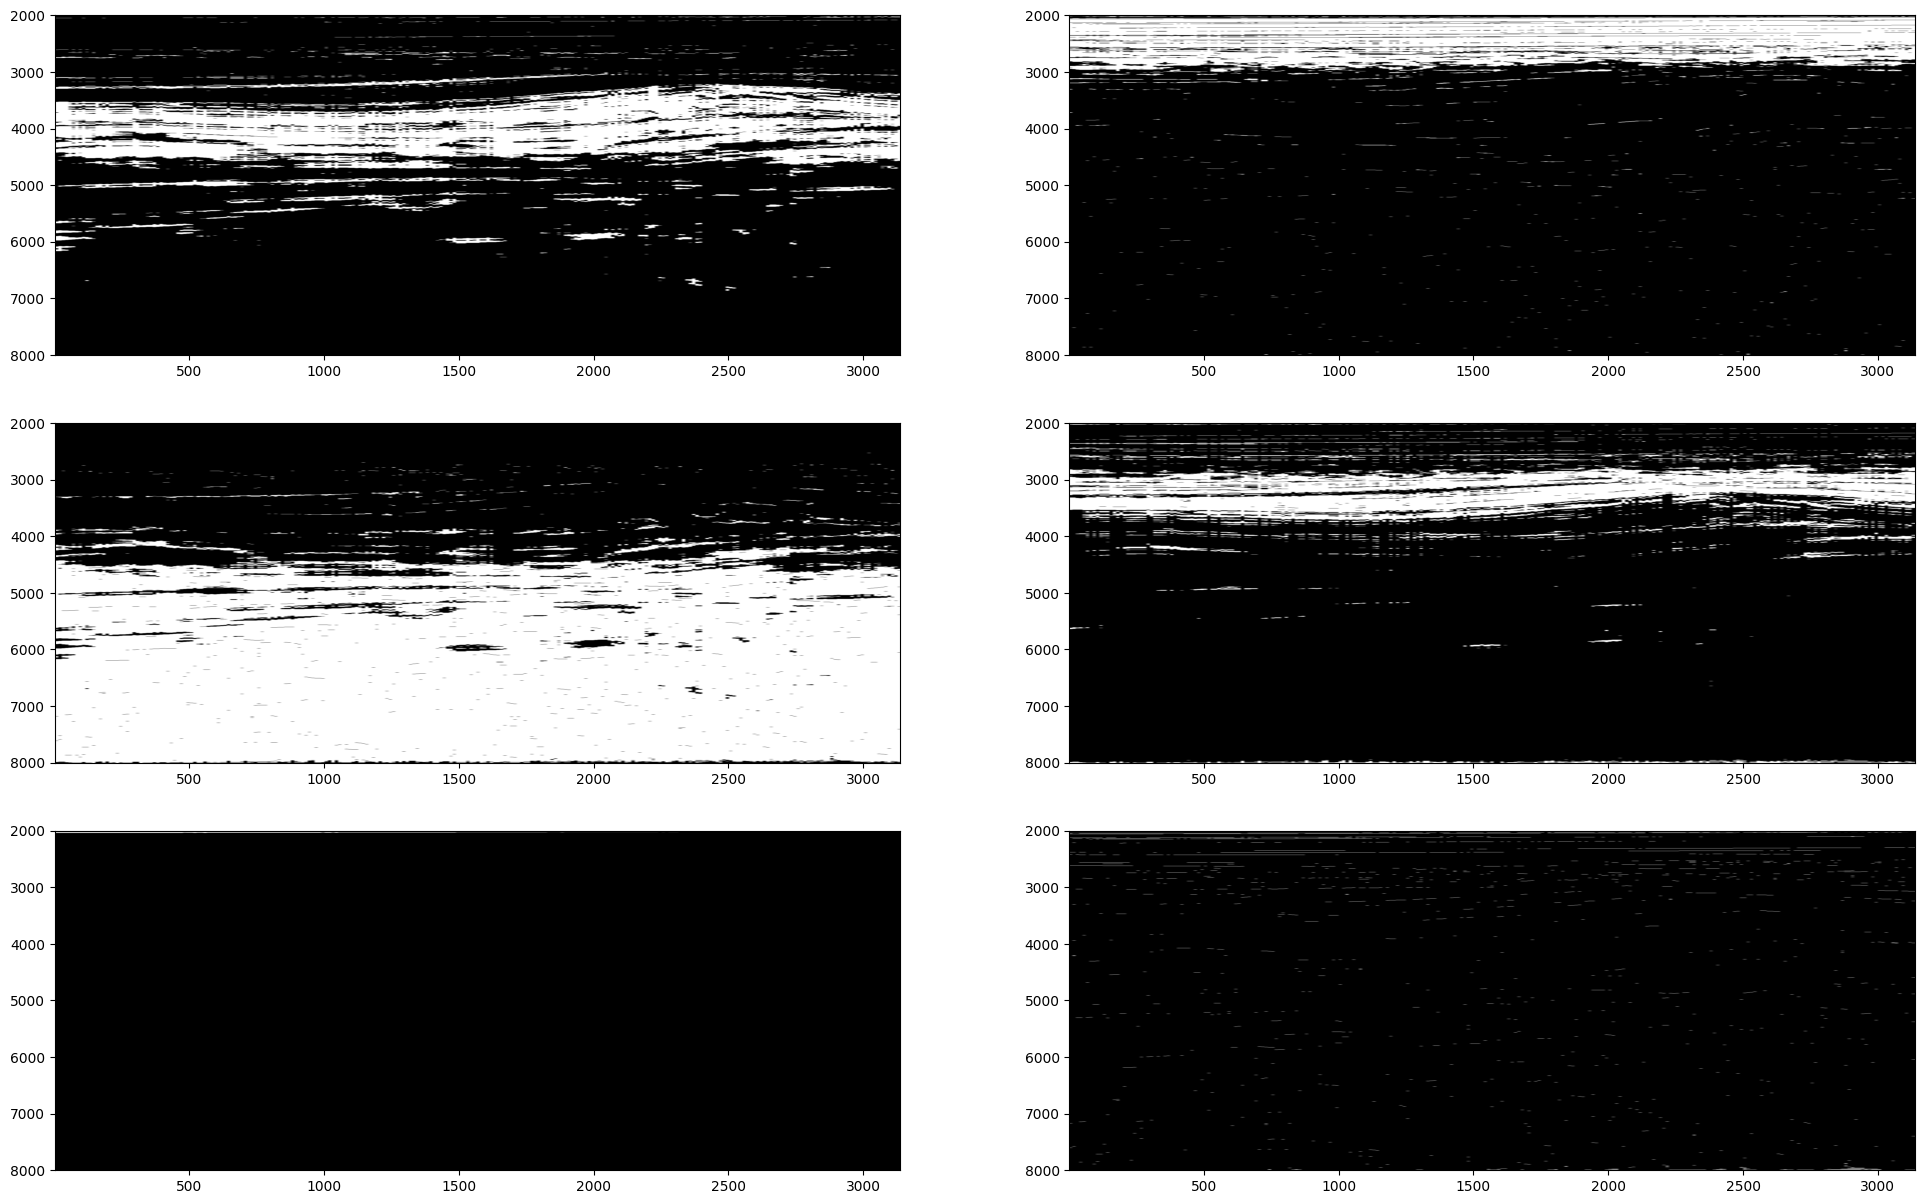

In [40]:
subplot(secao, [onehot[:, :, i] for i in range(onehot.shape[-1])], percentil = 100)